In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
# Cargar el archivo CSV en un DataFrame
dataset = pd.read_csv('/content/drive/MyDrive/TFM_CRC_MICROBIOME.csv')

print(dataset.head())

   Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

   d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_H  \
0                                           0.637630                                                
1                                           0.237705                                                
2                                           0.038784                                                
3                                           0.004594                                                
4                                           0.025618                                                

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales_A_737866;f__Enterobacteriaceae_A;g__Klebsiella_724518  \
0                                           0.307338                                                                                
1                       

In [ ]:
# Crear una lista de columnas a eliminar
columnas_a_eliminar = []

# Procesar cada columna excepto la primera y las dos últimas
for columna in dataset.columns[1:-2]:
    # Separar la columna por punto y coma
    separados = columna.split(';')

    # Verificar si se obtienen exactamente 6 nombres
    if len(separados) == 6:
        # Renombrar la columna con el último de los nombres
        nuevo_nombre = separados[-1]
        dataset = dataset.rename(columns={columna: nuevo_nombre})
    else:
        # Agregar a la lista de columnas a eliminar
        columnas_a_eliminar.append(columna)

# Eliminar las columnas que no cumplen con la condición
dataset = dataset.drop(columns=columnas_a_eliminar)

# Mostrar el dataframe procesado
print(dataset)

      Unnamed: 0  g__Bacteroides_H  g__Klebsiella_724518  g__Parvimonas  \
0              0          0.637630              0.307338       0.027949   
1              1          0.237705              0.000000       0.044057   
2              2          0.038784              0.000000       0.003641   
3              3          0.004594              0.000000       0.000000   
4              4          0.025618              0.000000       0.032154   
...          ...               ...                   ...            ...   
2843        2843          0.101386              0.000000       0.000000   
2844        2844          0.072412              0.000000       0.000000   
2845        2845          0.255244              0.000000       0.000243   
2846        2846          0.242867              0.000000       0.000000   
2847        2847          0.200762              0.000000       0.000000   

      g__Fusobacterium_C  g__Pygmaiobacter  g__Erysipelatoclostridium  \
0               0.017960  

In [ ]:
# Obtener los IDs únicos de la columna PRJA
unique_ids = dataset['PRJA'].unique()

# Dividir los IDs en train (80%) y test (20%)
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=0)

# Crear los dataframes de train y test basados en los IDs seleccionados
train_df = dataset[dataset['PRJA'].isin(train_ids)]
test_df = dataset[dataset['PRJA'].isin(test_ids)]

# Mostrar el tamaño de los conjuntos resultantes
print(f"Tamaño del conjunto de entrenamiento: {train_df.shape}")
print(f"Tamaño del conjunto de prueba: {test_df.shape}")

# Separar características (X) y etiquetas (y)
X_train = train_df.iloc[:, 1:-2]  # Todas las columnas excepto la primera, la penúltima y la última
y_train = train_df.iloc[:, -2]    # La penúltima columna es 'Label'
X_test = test_df.iloc[:, 1:-2]
y_test = test_df.iloc[:, -2]

Tamaño del conjunto de entrenamiento: (2632, 1255)
Tamaño del conjunto de prueba: (216, 1255)


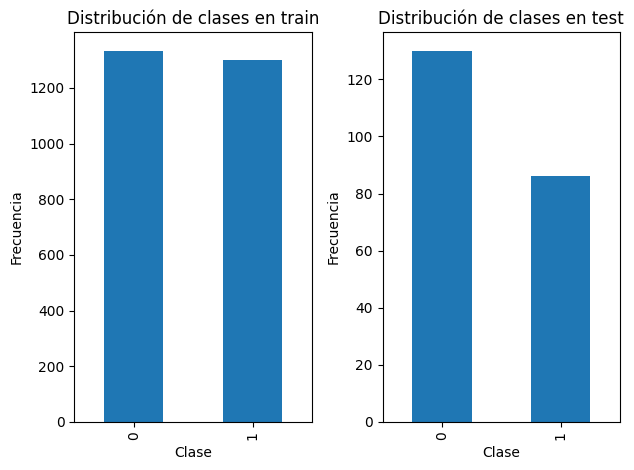

In [ ]:
# Histograma del conjunto de entrenamiento
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar')
plt.title('Distribución de clases en train')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')

# Histograma del conjunto de prueba
plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar')
plt.title('Distribución de clases en test')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# **Gradient Boosting**

In [ ]:
# Crear el modelo de Gradient Boosting
model = GradientBoostingClassifier(random_state=0)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Calcular las probabilidades de predicción (esto es necesario para calcular el AUC)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Selecciona las probabilidades de la clase positiva

# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

print(f"Accuracy: {accuracy}")

#print(f"Classification Report:\n{report}")

AUC: 0.7565295169946332
Accuracy: 0.7268518518518519


In [ ]:
# Función para eliminar columnas con baja desviación estándar y alta correlación
def feature_selection(X, std_threshold, corr_threshold):
    # Eliminar columnas con desviación estándar baja
    std = X.std()
    low_std_cols = std[std < std_threshold].index
    X = X.drop(columns=low_std_cols)

    # Eliminar columnas con alta correlación
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    X = X.drop(columns=high_corr_cols)

    return X

# Rango de umbrales a probar
std_thresholds = [0.00001,0.0001,0.0005,0.001,0.005,0.01, 0.02, 0.03,0.1,0.05]
corr_thresholds = [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85, 0.9, 0.95]

best_model = None
best_accuracy = 0
best_auc = 0
best_std_threshold = 0
best_corr_threshold = 0

for std_threshold in std_thresholds:
    for corr_threshold in corr_thresholds:
        # Seleccionar características
        X_train_selected = feature_selection(X_train, std_threshold, corr_threshold)
        X_test_selected = X_test[X_train_selected.columns]

        # Entrenar modelo
        model = GradientBoostingClassifier()
        model.fit(X_train_selected, y_train)

        # Evaluar modelo
        y_pred = model.predict(X_test_selected)
        y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        if accuracy > best_accuracy and auc > best_auc:
            best_model = model
            best_accuracy = accuracy
            best_auc = auc
            best_std_threshold = std_threshold
            best_corr_threshold = corr_threshold

print(f"Mejor modelo - Accuracy: {best_accuracy}, AUC: {best_auc}")
print(f"Umbral de desviación estándar: {best_std_threshold}")
print(f"Umbral de correlación: {best_corr_threshold}")

Mejor modelo - Accuracy: 0.7638888888888888, AUC: 0.7860465116279068
Umbral de desviación estándar: 0.005
Umbral de correlación: 0.45


In [ ]:
# Juntamos ambos DataFrames para obtener el resumen estadístico de todas las variables seleccionadas
X_selected = pd.concat([X_train_selected, X_test_selected], axis=0)

# Realizamos un describe del DataFrame con las variables seleccionadas
X_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2848 entries, 0 to 2812
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   g__Bacteroides_H         2848 non-null   float64
 1   g__Fusobacterium_C       2848 non-null   float64
 2   g__Phocaeicola_A_858004  2848 non-null   float64
 3   g__Faecalibacterium      2848 non-null   float64
 4   g__Blautia_A_141781      2848 non-null   float64
 5   g__Escherichia_710834    2848 non-null   float64
 6   g__Prevotella            2848 non-null   float64
 7   g__Akkermansia           2848 non-null   float64
dtypes: float64(8)
memory usage: 200.2 KB


# **Ensembles**

In [ ]:
from sklearn.ensemble import VotingClassifier

# Definir los modelos base
clf1 = GradientBoostingClassifier(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = MultinomialNB()

# Crear el ensemble
voting_clf = VotingClassifier(estimators=[
    ('gb', clf1), ('rf', clf2), ('NB', clf3)], voting='hard')

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
report_voting = classification_report(y_test, y_pred_voting)

print("Ensemble de Modelos")
print(f"Accuracy: {accuracy_voting}")
print(f"Classification Report:\n{report_voting}")

Ensemble de Modelos
Accuracy: 0.7592592592592593
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       130
           1       0.73      0.63      0.68        86

    accuracy                           0.76       216
   macro avg       0.75      0.74      0.74       216
weighted avg       0.76      0.76      0.76       216



**Ensemble duro**

In [ ]:
# Escalado para SVM y Regresión Logística
scaler = StandardScaler()

# Definir los modelos base con Pipeline para los que necesitan escalado
clf1 = GradientBoostingClassifier(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = MultinomialNB()
clf4 = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(random_state=0, max_iter=1000))])
clf5 = DecisionTreeClassifier(random_state=0)
clf6 = Pipeline([('scaler', scaler), ('svm', SVC(random_state=0, probability=True))])

# Crear el ensemble con votación dura
voting_clf = VotingClassifier(estimators=[
    ('gb', clf1), ('rf', clf2), ('NB', clf3), ('lr', clf4), ('dt', clf5), ('svm', clf6)], voting='hard')

# Ajustar el ensemble
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
report_voting = classification_report(y_test, y_pred_voting)

print("Ensemble de Modelos")
print(f"Accuracy: {accuracy_voting}")
print(f"Classification Report:\n{report_voting}")

Ensemble de Modelos
Accuracy: 0.7685185185185185
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       130
           1       0.76      0.62      0.68        86

    accuracy                           0.77       216
   macro avg       0.77      0.74      0.75       216
weighted avg       0.77      0.77      0.76       216



**Ensemble blando**

In [ ]:
# Escalado para SVM y Regresión Logística
scaler = StandardScaler()

# Definir los modelos base con Pipeline para los que necesitan escalado
clf1 = GradientBoostingClassifier(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = MultinomialNB()
clf4 = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(random_state=0, max_iter=1000))])
clf5 = DecisionTreeClassifier(random_state=0)
clf6 = Pipeline([('scaler', scaler), ('svm', SVC(random_state=0, probability=True))])

# Crear el ensemble con votación dura
voting_clf = VotingClassifier(estimators=[
    ('gb', clf1), ('rf', clf2), ('NB', clf3), ('lr', clf4), ('dt', clf5), ('svm', clf6)], voting='soft')

# Ajustar el ensemble
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
report_voting = classification_report(y_test, y_pred_voting)

print("Ensemble de Modelos")
print(f"Accuracy: {accuracy_voting}")
print(f"Classification Report:\n{report_voting}")

Ensemble de Modelos
Accuracy: 0.7222222222222222
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       130
           1       0.67      0.60      0.63        86

    accuracy                           0.72       216
   macro avg       0.71      0.70      0.71       216
weighted avg       0.72      0.72      0.72       216



**Ensemble con SMOTE**

In [ ]:
# Aplicar SMOTE para manejar el desbalance de clases
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalado para SVM y Regresión Logística
scaler = StandardScaler()

# Definir los modelos base con Pipeline para los que necesitan escalado
clf1 = GradientBoostingClassifier(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = MultinomialNB()
clf4 = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(random_state=0, max_iter=1000))])
clf5 = DecisionTreeClassifier(random_state=0)
clf6 = Pipeline([('scaler', scaler), ('svm', SVC(random_state=0, probability=True))])

# Crear el ensemble con votación dura
voting_clf = VotingClassifier(estimators=[
    ('gb', clf1), ('rf', clf2), ('NB', clf3), ('lr', clf4), ('dt', clf5), ('svm', clf6)], voting='hard')

# Ajustar el ensemble con los datos re-muestreados
voting_clf.fit(X_train_resampled, y_train_resampled)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
report_voting = classification_report(y_test, y_pred_voting)

print("Ensemble de Modelos con SMOTE")
print(f"Accuracy: {accuracy_voting}")
print(f"Classification Report:\n{report_voting}")

Ensemble de Modelos con SMOTE
Accuracy: 0.7731481481481481
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       130
           1       0.75      0.64      0.69        86

    accuracy                           0.77       216
   macro avg       0.77      0.75      0.76       216
weighted avg       0.77      0.77      0.77       216



In [ ]:
# Aplicar SMOTE para manejar el desbalance de clases
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalado para SVM, Regresión Logística y KNN
scaler = StandardScaler()

# Definir los modelos base con Pipeline para los que necesitan escalado
clf1 = GradientBoostingClassifier(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
#clf3 = MultinomialNB()
clf4 = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(random_state=0, max_iter=1000))])
clf5 = DecisionTreeClassifier(random_state=0)
#clf6 = Pipeline([('scaler', scaler), ('svm', SVC(random_state=0, probability=True))])
clf7 = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier())])  # KNN por defecto k=5

# Crear el ensemble con votación suave para calcular AUC
voting_clf = VotingClassifier(estimators=[
    ('gb', clf1), ('rf', clf2), ('lr', clf4), ('dt', clf5), ('knn', clf7)], voting='soft')

# Ajustar el ensemble con los datos re-muestreados
voting_clf.fit(X_train_resampled, y_train_resampled)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
report_voting = classification_report(y_test, y_pred_voting)

# Calcular AUC para el ensemble
y_pred_proba_voting = voting_clf.predict_proba(X_test)[:, 1]
auc_voting = roc_auc_score(y_test, y_pred_proba_voting)

print("Ensemble de Modelos con SMOTE")
print(f"Accuracy: {accuracy_voting}")
print(f"AUC: {auc_voting}")
print(f"Classification Report:\n{report_voting}")

Ensemble de Modelos con SMOTE
Accuracy: 0.7361111111111112
AUC: 0.8098389982110914
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       130
           1       0.69      0.62      0.65        86

    accuracy                           0.74       216
   macro avg       0.73      0.72      0.72       216
weighted avg       0.73      0.74      0.73       216



In [ ]:
# Aplicar SMOTE para manejar el desbalance de clases
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalado para SVM, Regresión Logística y KNN
scaler = StandardScaler()

# Definir los modelos base con Pipeline para los que necesitan escalado
clf1 = GradientBoostingClassifier(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
#clf3 = MultinomialNB()
clf4 = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(random_state=0, max_iter=1000))])
clf5 = DecisionTreeClassifier(random_state=0)
#clf6 = Pipeline([('scaler', scaler), ('svm', SVC(random_state=0, probability=True))])
clf7 = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier())])  # KNN por defecto k=5

# Crear el ensemble con votación suave para calcular AUC
voting_clf = VotingClassifier(estimators=[
    ('gb', clf1), ('rf', clf2), ('lr', clf4), ('dt', clf5), ('knn', clf7)], voting='hard')

# Ajustar el ensemble con los datos re-muestreados
voting_clf.fit(X_train_resampled, y_train_resampled)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
report_voting = classification_report(y_test, y_pred_voting)


print("Ensemble de Modelos con SMOTE")
print(f"Accuracy: {accuracy_voting}")
print(f"Classification Report:\n{report_voting}")

Ensemble de Modelos con SMOTE
Accuracy: 0.7638888888888888
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       130
           1       0.73      0.65      0.69        86

    accuracy                           0.76       216
   macro avg       0.76      0.74      0.75       216
weighted avg       0.76      0.76      0.76       216



In [ ]:
# Escalado para SVM, Regresión Logística y KNN
scaler = StandardScaler()

# Definir los modelos base con Pipeline para los que necesitan escalado
clf1 = GradientBoostingClassifier(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
#clf3 = MultinomialNB()
clf4 = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(random_state=0, max_iter=1000))])
clf5 = DecisionTreeClassifier(random_state=0)
#clf6 = Pipeline([('scaler', scaler), ('svm', SVC(random_state=0, probability=True))])
clf7 = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier())])  # KNN por defecto k=5

# Crear el ensemble con votación suave para calcular AUC
voting_clf = VotingClassifier(estimators=[
    ('gb', clf1), ('rf', clf2), ('lr', clf4), ('dt', clf5), ('knn', clf7)], voting='soft')

# Ajustar el ensemble con los datos originales
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
report_voting = classification_report(y_test, y_pred_voting)

# Calcular AUC para el ensemble
y_pred_proba_voting = voting_clf.predict_proba(X_test)[:, 1]
auc_voting = roc_auc_score(y_test, y_pred_proba_voting)

print("Ensemble de Modelos (Sin SMOTE)")
print(f"Accuracy: {accuracy_voting}")
print(f"AUC: {auc_voting}")
print(f"Classification Report:\n{report_voting}")

Ensemble de Modelos (Sin SMOTE)
Accuracy: 0.7407407407407407
AUC: 0.8083184257602861
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       130
           1       0.70      0.60      0.65        86

    accuracy                           0.74       216
   macro avg       0.73      0.72      0.72       216
weighted avg       0.74      0.74      0.74       216



In [ ]:
# Escalado para SVM, Regresión Logística y KNN
scaler = StandardScaler()

# Definir los modelos base con Pipeline para los que necesitan escalado
clf1 = GradientBoostingClassifier(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
#clf3 = MultinomialNB()
clf4 = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(random_state=0, max_iter=1000))])
clf5 = DecisionTreeClassifier(random_state=0)
#clf6 = Pipeline([('scaler', scaler), ('svm', SVC(random_state=0, probability=True))])
clf7 = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier())])  # KNN por defecto k=5

# Crear el ensemble con votación suave para calcular AUC
voting_clf = VotingClassifier(estimators=[
    ('gb', clf1), ('rf', clf2), ('lr', clf4), ('dt', clf5), ('knn', clf7)], voting='hard')

# Ajustar el ensemble con los datos originales
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
report_voting = classification_report(y_test, y_pred_voting)

print("Ensemble de Modelos (Sin SMOTE)")
print(f"Accuracy: {accuracy_voting}")
print(f"Classification Report:\n{report_voting}")

Ensemble de Modelos (Sin SMOTE)
Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       130
           1       0.71      0.63      0.67        86

    accuracy                           0.75       216
   macro avg       0.74      0.73      0.73       216
weighted avg       0.75      0.75      0.75       216



**Eliminando características**

Con validación cruzada respecto AUC:

In [ ]:
# Definir la función para seleccionar características
def feature_selection(X, std_threshold, corr_threshold):
    # Eliminar columnas con desviación estándar baja
    std = X.std()
    low_std_cols = std[std < std_threshold].index
    X = X.drop(columns=low_std_cols)

    # Eliminar columnas con alta correlación
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    X = X.drop(columns=high_corr_cols)

    return X

# Rango de umbrales a probar
std_thresholds = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.03, 0.1, 0.05]
corr_thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

best_model = None
best_accuracy = 0
best_auc = 0
best_std_threshold = 0
best_corr_threshold = 0
selected_columns = None

for std_threshold in std_thresholds:
    for corr_threshold in corr_thresholds:
        # Seleccionar características
        X_train_selected = feature_selection(X_train, std_threshold, corr_threshold)
        X_test_selected = X_test[X_train_selected.columns]

        # Definir los modelos base con Pipeline para los que necesitan escalado
        scaler = StandardScaler()
        clf1 = GradientBoostingClassifier(random_state=0)
        clf2 = RandomForestClassifier(random_state=0)
        clf4 = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(random_state=0, max_iter=1000))])
        clf5 = DecisionTreeClassifier(random_state=0)
        clf7 = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier())])  # KNN por defecto k=5

        # Crear el ensemble con votación suave
        voting_clf = VotingClassifier(estimators=[
            ('gb', clf1), ('rf', clf2), ('lr', clf4), ('dt', clf5), ('knn', clf7)], voting='soft')

        # Realizar validación cruzada y calcular AUC
        auc_scores = cross_val_score(voting_clf, X_train_selected, y_train, cv=5, scoring='roc_auc')
        mean_auc = np.mean(auc_scores)

        if mean_auc > best_auc:
            best_model = voting_clf
            best_auc = mean_auc
            best_std_threshold = std_threshold
            best_corr_threshold = corr_threshold
            selected_columns = X_train_selected.columns

# Ajustar el mejor modelo encontrado con todos los datos de entrenamiento
best_model.fit(X_train[selected_columns], y_train)

# Evaluar el mejor modelo en el conjunto de prueba
X_test_final = X_test[selected_columns]  # Asegurarse de usar las mismas columnas seleccionadas
y_pred_best = best_model.predict(X_test_final)
y_pred_proba_best = best_model.predict_proba(X_test_final)[:, 1]

accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_pred_proba_best)
report_best = classification_report(y_test, y_pred_best)

print(f"Mejor modelo - Accuracy: {accuracy_best}, AUC: {auc_best}")
print(f"Umbral de desviación estándar: {best_std_threshold}")
print(f"Umbral de correlación: {best_corr_threshold}")
print("Ensemble de Modelos con Selección de Características")
print(f"Classification Report:\n{report_best}")

Mejor modelo - Accuracy: 0.75, AUC: 0.7765652951699463
Umbral de desviación estándar: 0.0005
Umbral de correlación: 0.85
Ensemble de Modelos con Selección de Características
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       130
           1       0.73      0.59      0.65        86

    accuracy                           0.75       216
   macro avg       0.74      0.72      0.73       216
weighted avg       0.75      0.75      0.74       216



In [ ]:
from sklearn.model_selection import cross_val_score

# Definir la función para seleccionar características
def feature_selection(X, std_threshold, corr_threshold):
    # Eliminar columnas con desviación estándar baja
    std = X.std()
    low_std_cols = std[std < std_threshold].index
    X = X.drop(columns=low_std_cols)

    # Eliminar columnas con alta correlación
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    X = X.drop(columns=high_corr_cols)

    return X

# Rango de umbrales a probar
std_thresholds = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.03, 0.1, 0.05]
corr_thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

best_model = None
best_accuracy = 0
best_auc = 0
best_std_threshold = 0
best_corr_threshold = 0
selected_columns = None

for std_threshold in std_thresholds:
    for corr_threshold in corr_thresholds:
        # Seleccionar características
        X_train_selected = feature_selection(X_train, std_threshold, corr_threshold)
        X_test_selected = X_test[X_train_selected.columns]

        # Aplicar SMOTE para manejar el desbalance de clases
        smote = SMOTE(random_state=0)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

        # Definir los modelos base con Pipeline para los que necesitan escalado
        scaler = StandardScaler()
        clf1 = GradientBoostingClassifier(random_state=0)
        clf2 = RandomForestClassifier(random_state=0)
        #clf3 = MultinomialNB()
        clf4 = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(random_state=0, max_iter=1000))])
        clf5 = DecisionTreeClassifier(random_state=0)
        #clf6 = Pipeline([('scaler', scaler), ('svm', SVC(random_state=0, probability=True))])
        clf7 = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier())])  # KNN por defecto k=5

        # Crear el ensemble con votación suave
        voting_clf = VotingClassifier(estimators=[
            ('gb', clf1), ('rf', clf2), ('lr', clf4), ('dt', clf5), ('knn', clf7)], voting='soft')

        # Realizar validación cruzada y calcular AUC
        auc_scores = cross_val_score(voting_clf, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
        mean_auc = np.mean(auc_scores)

        if mean_auc > best_auc:
            best_model = voting_clf
            best_auc = mean_auc
            best_std_threshold = std_threshold
            best_corr_threshold = corr_threshold
            selected_columns = X_train_selected.columns

# Ajustar el mejor modelo encontrado con todos los datos de entrenamiento
best_model.fit(X_train[selected_columns], y_train)

# Evaluar el mejor modelo en el conjunto de prueba
X_test_final = X_test[selected_columns]  # Asegurarse de usar las mismas columnas seleccionadas
y_pred_best = best_model.predict(X_test_final)
y_pred_proba_best = best_model.predict_proba(X_test_final)[:, 1]

accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_pred_proba_best)
report_best = classification_report(y_test, y_pred_best)

print(f"Mejor modelo - Accuracy: {accuracy_best}, AUC: {auc_best}")
print(f"Umbral de desviación estándar: {best_std_threshold}")
print(f"Umbral de correlación: {best_corr_threshold}")
print("Ensemble de Modelos con SMOTE y Selección de Características")
print(f"Classification Report:\n{report_best}")

Mejor modelo - Accuracy: 0.7962962962962963, AUC: 0.8203935599284438
Umbral de desviación estándar: 0.0001
Umbral de correlación: 0.65
Ensemble de Modelos con SMOTE y Selección de Características
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       130
           1       0.76      0.71      0.73        86

    accuracy                           0.80       216
   macro avg       0.79      0.78      0.78       216
weighted avg       0.79      0.80      0.79       216



In [ ]:
# Función para seleccionar características basadas en correlación con la variable objetivo
def feature_selection_by_target_corr(X, y, target_corr_threshold):
    corr_with_target = X.corrwith(y).abs()
    selected_features = corr_with_target[corr_with_target > target_corr_threshold].index
    return X[selected_features]

# Rango de umbrales a probar
target_corr_thresholds = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.05, 0.005, 0.0005, 0.00005]

best_model_final = None
best_accuracy_final = 0
best_auc_final = 0
best_target_corr_threshold = 0
final_selected_columns = None

for target_corr_threshold in target_corr_thresholds:
    # Seleccionar características basadas en correlación con la variable objetivo
    X_train_selected_final = feature_selection_by_target_corr(X_train[selected_columns], y_train, target_corr_threshold)
    X_test_selected_final = X_test[X_train_selected_final.columns]

    # Aplicar SMOTE para manejar el desbalance de clases
    smote = SMOTE(random_state=0)
    X_train_resampled_final, y_train_resampled_final = smote.fit_resample(X_train_selected_final, y_train)

    # Utilizar el mejor modelo encontrado en la celda anterior
    best_model_final = best_model

    # Realizar validación cruzada y calcular AUC
    auc_scores_final = cross_val_score(best_model_final, X_train_resampled_final, y_train_resampled_final, cv=5, scoring='roc_auc')
    mean_auc_final = np.mean(auc_scores_final)

    if mean_auc_final > best_auc_final:
        best_auc_final = mean_auc_final
        best_target_corr_threshold = target_corr_threshold
        final_selected_columns = X_train_selected_final.columns

# Ajustar el mejor modelo encontrado con todos los datos de entrenamiento seleccionados
best_model_final.fit(X_train[final_selected_columns], y_train)

# Evaluar el mejor modelo en el conjunto de prueba
X_test_final_selected = X_test[final_selected_columns]  # Asegurarse de usar las mismas columnas seleccionadas
y_pred_final = best_model_final.predict(X_test_final_selected)
y_pred_proba_final = best_model_final.predict_proba(X_test_final_selected)[:, 1]

accuracy_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_pred_proba_final)
report_final = classification_report(y_test, y_pred_final)

print(f"Mejor modelo final - Accuracy: {accuracy_final}, AUC: {auc_final}")
print(f"Umbral de correlación con la variable objetivo: {best_target_corr_threshold}")
print("Ensemble de Modelos con SMOTE y Selección de Características por Correlación con Variable Objetivo")
print(f"Classification Report:\n{report_final}")

Mejor modelo final - Accuracy: 0.7268518518518519, AUC: 0.7571556350626117
Umbral de correlación con la variable objetivo: 0.1
Ensemble de Modelos con SMOTE y Selección de Características por Correlación con Variable Objetivo
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       130
           1       0.68      0.60      0.64        86

    accuracy                           0.73       216
   macro avg       0.72      0.71      0.71       216
weighted avg       0.72      0.73      0.72       216



In [ ]:
# Número de variables seleccionadas
print(f"Número de variables seleccionadas: {len(selected_columns)}")

# Mostrar las columnas seleccionadas
print(f"Columnas seleccionadas: {selected_columns}")

Número de variables seleccionadas: 498
Columnas seleccionadas: Index(['g__Bacteroides_H', 'g__Klebsiella_724518', 'g__Parvimonas',
       'g__Fusobacterium_C', 'g__Pygmaiobacter', 'g__Erysipelatoclostridium',
       'g__Bulleidia', 'g__Enterococcus_H_360604', 'g__Holdemanella',
       'g__Mediterraneibacter_A_155507',
       ...
       'g__UBA2730', 'g__OLB17_426821', 'g__Gleimia',
       'g__Pseudoglutamicibacter', 'g__Gallalistipes', 'g__UBA4951',
       'g__VUNI01', 'g__Helicobacter_B', 'g__Tepidiphilus', 'g__UBA1067'],
      dtype='object', length=498)


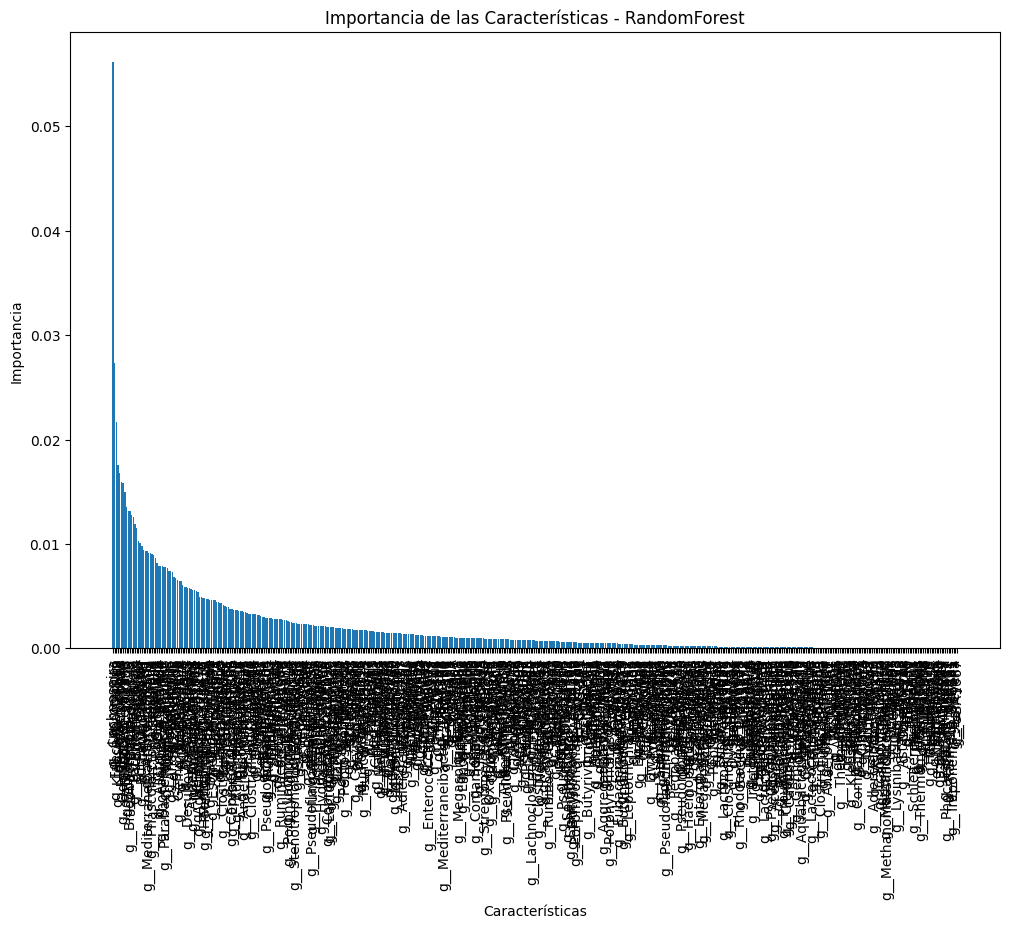

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer el modelo RandomForest del ensemble
rf_model = best_model.named_estimators_['rf']

# Obtener las importancias de las características
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Crear el plot
plt.figure(figsize=(12, 8))
plt.title("Importancia de las Características - RandomForest")
plt.bar(range(len(selected_columns)), importances[indices], align="center")
plt.xticks(range(len(selected_columns)), [selected_columns[i] for i in indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.show()

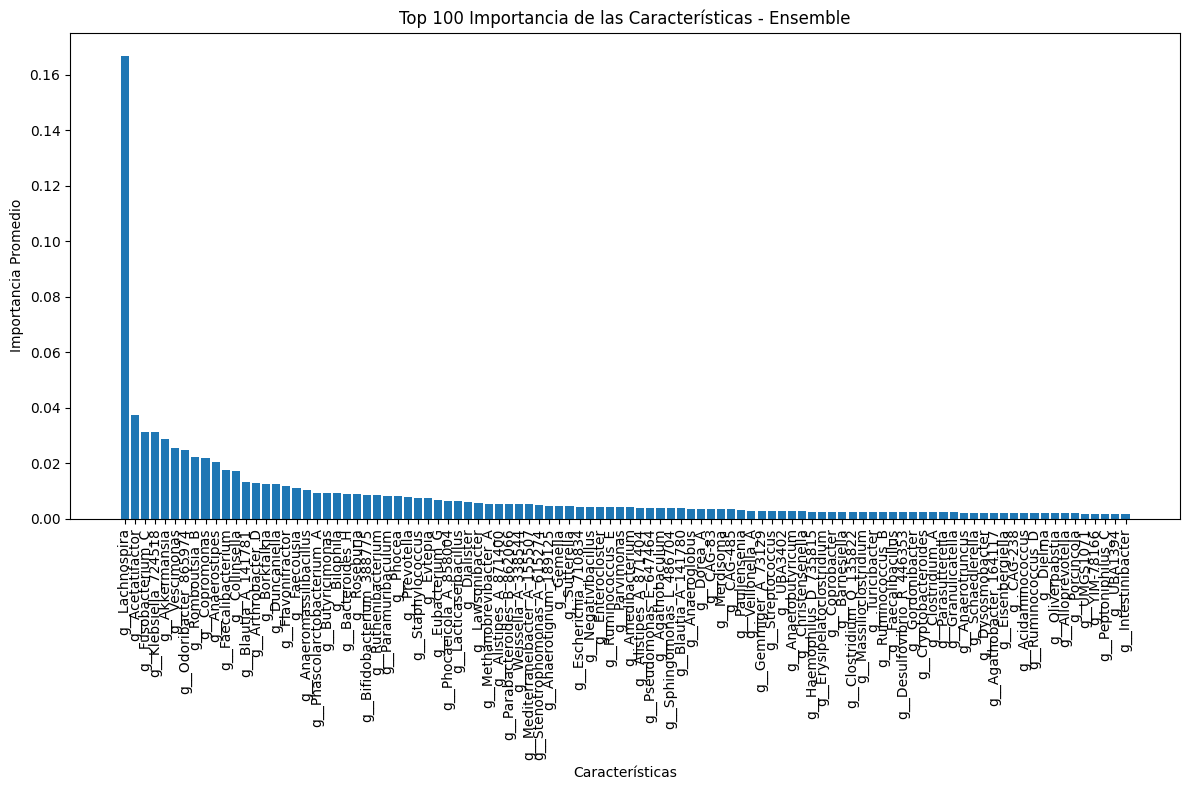

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener la lista de importancias de todos los modelos
importances_list = []
for name, clf in best_model.named_estimators_.items():
    if hasattr(clf, 'feature_importances_'):
        importances_list.append(clf.feature_importances_)
    elif hasattr(clf, 'coef_'):
        importances_list.append(np.abs(clf.coef_[0]))  # Para modelos lineales como la regresión logística

# Promediar las importancias (ajustar según el número de características)
average_importances = np.mean(importances_list, axis=0)

# Ordenar las importancias
indices = np.argsort(average_importances)[::-1]

# Seleccionar las 100 características más importantes
top_n = 100
top_indices = indices[:top_n]
top_features = [selected_columns[i] for i in top_indices]
top_importances = average_importances[top_indices]

# Crear el plot
plt.figure(figsize=(12, 8))
plt.title("Top 100 Importancia de las Características - Ensemble")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_features, rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia Promedio")
plt.tight_layout()
plt.show()

In [ ]:
# Obtener la lista de importancias de todos los modelos
importances_list = []
for name, clf in best_model.named_estimators_.items():
    if hasattr(clf, 'feature_importances_'):
        importances_list.append(clf.feature_importances_)
    elif hasattr(clf, 'coef_'):
        importances_list.append(np.abs(clf.coef_[0]))  # Para modelos lineales como la regresión logística

# Promediar las importancias (ajustar según el número de características)
average_importances = np.mean(importances_list, axis=0)

# Ordenar las importancias
indices = np.argsort(average_importances)[::-1]

# Seleccionar las 100 características más importantes
top_n = 498
top_indices = indices[:top_n]
top_features = [selected_columns[i] for i in top_indices]

# Crear nuevos conjuntos de datos solo con las 100 características más importantes
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Aplicar SMOTE para manejar el desbalance de clases
smote = SMOTE(random_state=0)
X_train_resampled_top, y_train_resampled_top = smote.fit_resample(X_train_top, y_train)

# Ajustar el mejor modelo encontrado con las 100 características más importantes
best_model.fit(X_train_resampled_top, y_train_resampled_top)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred_best_top = best_model.predict(X_test_top)
y_pred_proba_best_top = best_model.predict_proba(X_test_top)[:, 1]

accuracy_best_top = accuracy_score(y_test, y_pred_best_top)
auc_best_top = roc_auc_score(y_test, y_pred_proba_best_top)
report_best_top = classification_report(y_test, y_pred_best_top)

print(f"Mejor modelo con 100 características - Accuracy: {accuracy_best_top}, AUC: {auc_best_top}")
print("Ensemble de Modelos con SMOTE y Selección de las 100 Características Más Importantes")
print(f"Classification Report:\n{report_best_top}")

Mejor modelo con 100 características - Accuracy: 0.6898148148148148, AUC: 0.7521466905187836
Ensemble de Modelos con SMOTE y Selección de las 100 Características Más Importantes
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       130
           1       0.59      0.72      0.65        86

    accuracy                           0.69       216
   macro avg       0.69      0.70      0.69       216
weighted avg       0.71      0.69      0.69       216



In [ ]:
# Definir la función para seleccionar características
def feature_selection(X, y, std_threshold, corr_threshold, low_corr_threshold):
    # Eliminar columnas con desviación estándar baja
    std = X.std()
    low_std_cols = std[std < std_threshold].index
    X = X.drop(columns=low_std_cols)

    # Eliminar columnas con alta correlación
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    X = X.drop(columns=high_corr_cols)

    # Eliminar columnas con baja correlación con la variable objetivo
    target_corr = X.apply(lambda col: np.abs(np.corrcoef(col, y)[0, 1]))
    low_target_corr_cols = target_corr[target_corr < low_corr_threshold].index
    X = X.drop(columns=low_target_corr_cols)

    return X

# Rango de umbrales a probar
std_thresholds = [0.00001, 0.0001, 0.001, 0.01]
corr_thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
low_corr_thresholds = [0.01, 0.001, 0.0001, 0.00001]

best_model = None
best_accuracy = 0
best_auc = 0
best_std_threshold = 0
best_corr_threshold = 0
best_low_corr_threshold = 0
selected_columns = None

for std_threshold in std_thresholds:
    for corr_threshold in corr_thresholds:
        for low_corr_threshold in low_corr_thresholds:
            # Seleccionar características
            X_train_selected = feature_selection(X_train, y_train, std_threshold, corr_threshold, low_corr_threshold)
            X_test_selected = X_test[X_train_selected.columns]

            # Aplicar SMOTE para manejar el desbalance de clases
            smote = SMOTE(random_state=0)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

            # Definir los modelos base con Pipeline para los que necesitan escalado
            scaler = StandardScaler()
            clf1 = GradientBoostingClassifier(random_state=0)
            clf2 = RandomForestClassifier(random_state=0)
            clf3 = MultinomialNB()
            clf4 = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(random_state=0, max_iter=1000))])
            clf5 = DecisionTreeClassifier(random_state=0)
            clf6 = Pipeline([('scaler', scaler), ('svm', SVC(random_state=0, probability=True))])
            clf7 = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier())])  # KNN por defecto k=5

            # Crear el ensemble con votación suave
            voting_clf = VotingClassifier(estimators=[
                ('gb', clf1), ('rf', clf2), ('NB', clf3), ('lr', clf4), ('dt', clf5), ('svm', clf6), ('knn', clf7)], voting='soft')

            # Realizar validación cruzada y calcular AUC
            auc_scores = cross_val_score(voting_clf, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
            mean_auc = np.mean(auc_scores)

            if mean_auc > best_auc:
                best_model = voting_clf
                best_auc = mean_auc
                best_std_threshold = std_threshold
                best_corr_threshold = corr_threshold
                best_low_corr_threshold = low_corr_threshold
                selected_columns = X_train_selected.columns

# Ajustar el mejor modelo encontrado con todos los datos de entrenamiento
best_model.fit(X_train[selected_columns], y_train)

# Evaluar el mejor modelo en el conjunto de prueba
X_test_final = X_test[selected_columns]  # Asegurarse de usar las mismas columnas seleccionadas
y_pred_best = best_model.predict(X_test_final)
y_pred_proba_best = best_model.predict_proba(X_test_final)[:, 1]

accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_pred_proba_best)
report_best = classification_report(y_test, y_pred_best)

print(f"Mejor modelo - Accuracy: {accuracy_best}, AUC: {auc_best}")
print(f"Umbral de desviación estándar: {best_std_threshold}")
print(f"Umbral de correlación alta: {best_corr_threshold}")
print(f"Umbral de correlación baja: {best_low_corr_threshold}")
print("Ensemble de Modelos con SMOTE y Selección de Características")
print(f"Classification Report:\n{report_best}")

Mejor modelo - Accuracy: 0.7685185185185185, AUC: 0.8095706618962433
Umbral de desviación estándar: 1e-05
Umbral de correlación alta: 0.85
Umbral de correlación baja: 0.01
Ensemble de Modelos con SMOTE y Selección de Características
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       130
           1       0.70      0.73      0.72        86

    accuracy                           0.77       216
   macro avg       0.76      0.76      0.76       216
weighted avg       0.77      0.77      0.77       216



In [ ]:
# Número de variables seleccionadas
print(f"Número de variables seleccionadas: {len(selected_columns)}")

# Mostrar las columnas seleccionadas
print(f"Columnas seleccionadas: {selected_columns}")

Número de variables seleccionadas: 795
Columnas seleccionadas: Index(['g__Bacteroides_H', 'g__Klebsiella_724518', 'g__Parvimonas',
       'g__Fusobacterium_C', 'g__Pygmaiobacter', 'g__Erysipelatoclostridium',
       'g__Bulleidia', 'g__Enterococcus_H_360604', 'g__Holdemanella',
       'g__Mediterraneibacter_A_155507',
       ...
       'g__Marseille-P2935', 'g__Clostridium_AA', 'g__Selenomonas_A',
       'g__Arcanobacterium_A_386370', 'g__SFTJ01', 'g__Helicobacter_B',
       'g__Tepidiphilus', 'g__Lichenihabitans', 'g__Pseudomonas_E_650325',
       'g__Onthovivens'],
      dtype='object', length=795)


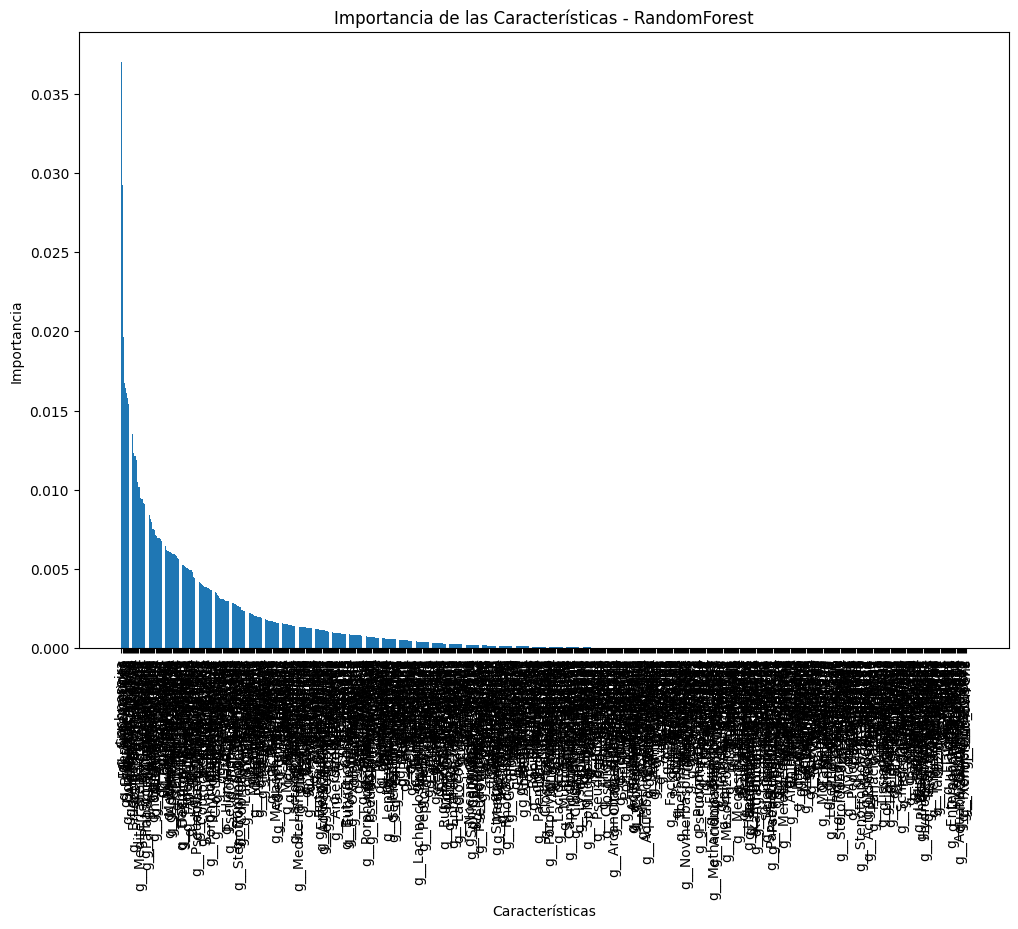

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer el modelo RandomForest del ensemble
rf_model = best_model.named_estimators_['rf']

# Obtener las importancias de las características
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Crear el plot
plt.figure(figsize=(12, 8))
plt.title("Importancia de las Características - RandomForest")
plt.bar(range(len(selected_columns)), importances[indices], align="center")
plt.xticks(range(len(selected_columns)), [selected_columns[i] for i in indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.show()

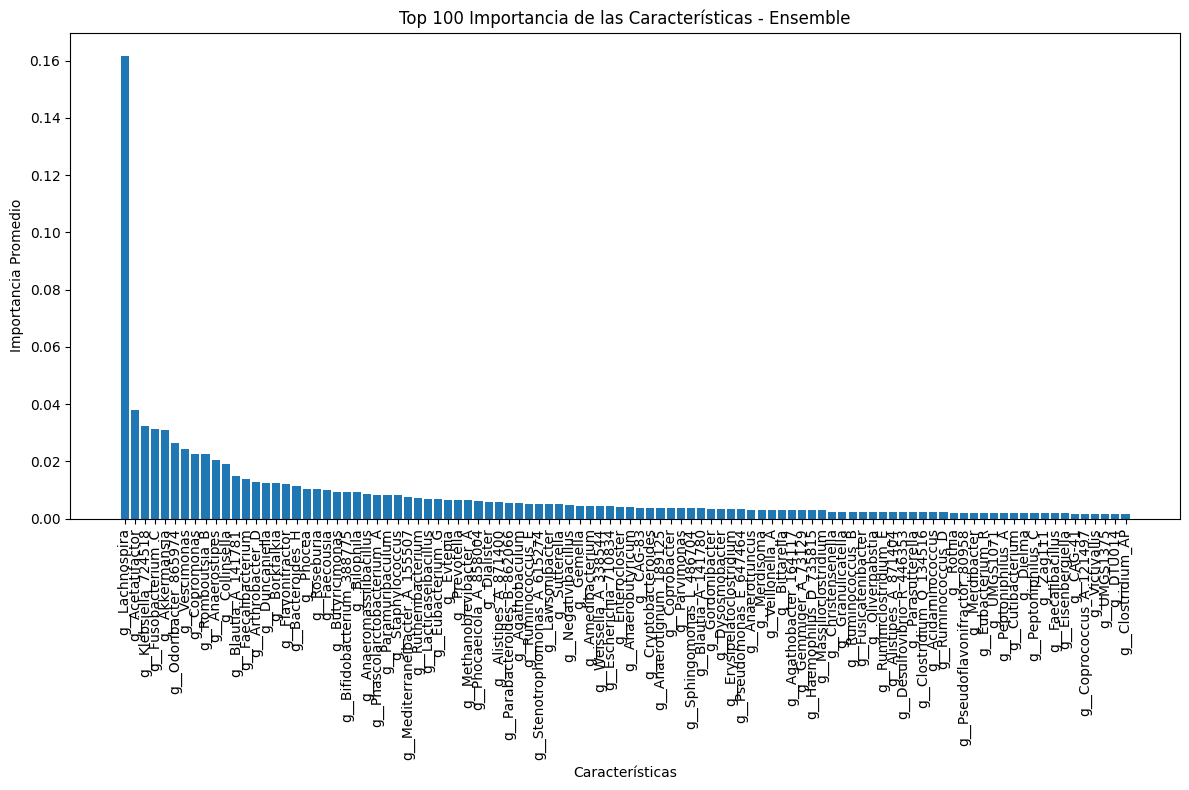

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener la lista de importancias de todos los modelos
importances_list = []
for name, clf in best_model.named_estimators_.items():
    if hasattr(clf, 'feature_importances_'):
        importances_list.append(clf.feature_importances_)
    elif hasattr(clf, 'coef_'):
        importances_list.append(np.abs(clf.coef_[0]))  # Para modelos lineales como la regresión logística

# Promediar las importancias (ajustar según el número de características)
average_importances = np.mean(importances_list, axis=0)

# Ordenar las importancias
indices = np.argsort(average_importances)[::-1]

# Seleccionar las 100 características más importantes
top_n = 100
top_indices = indices[:top_n]
top_features = [selected_columns[i] for i in top_indices]
top_importances = average_importances[top_indices]

# Crear el plot
plt.figure(figsize=(12, 8))
plt.title("Top 100 Importancia de las Características - Ensemble")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_features, rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia Promedio")
plt.tight_layout()
plt.show()

In [ ]:
# Obtener la lista de importancias de todos los modelos
importances_list = []
for name, clf in best_model.named_estimators_.items():
    if hasattr(clf, 'feature_importances_'):
        importances_list.append(clf.feature_importances_)
    elif hasattr(clf, 'coef_'):
        importances_list.append(np.abs(clf.coef_[0]))  # Para modelos lineales como la regresión logística

# Promediar las importancias (ajustar según el número de características)
average_importances = np.mean(importances_list, axis=0)

# Ordenar las importancias
indices = np.argsort(average_importances)[::-1]

# Seleccionar las 100 características más importantes
top_n = 10
top_indices = indices[:top_n]
top_features = [selected_columns[i] for i in top_indices]

# Crear nuevos conjuntos de datos solo con las 100 características más importantes
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Aplicar SMOTE para manejar el desbalance de clases
smote = SMOTE(random_state=0)
X_train_resampled_top, y_train_resampled_top = smote.fit_resample(X_train_top, y_train)

# Ajustar el mejor modelo encontrado con las 100 características más importantes
best_model.fit(X_train_resampled_top, y_train_resampled_top)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred_best_top = best_model.predict(X_test_top)
y_pred_proba_best_top = best_model.predict_proba(X_test_top)[:, 1]

accuracy_best_top = accuracy_score(y_test, y_pred_best_top)
auc_best_top = roc_auc_score(y_test, y_pred_proba_best_top)
report_best_top = classification_report(y_test, y_pred_best_top)

print(f"Mejor modelo con 100 características - Accuracy: {accuracy_best_top}, AUC: {auc_best_top}")
print("Ensemble de Modelos con SMOTE y Selección de las 100 Características Más Importantes")
print(f"Classification Report:\n{report_best_top}")

Mejor modelo con 100 características - Accuracy: 0.5185185185185185, AUC: 0.5760286225402504
Ensemble de Modelos con SMOTE y Selección de las 100 Características Más Importantes
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.38      0.49       130
           1       0.44      0.72      0.54        86

    accuracy                           0.52       216
   macro avg       0.56      0.55      0.52       216
weighted avg       0.58      0.52      0.51       216



Validación cruzada respecto accuracy:

In [ ]:
# Definir la función para seleccionar características
def feature_selection(X, std_threshold, corr_threshold):
    # Eliminar columnas con desviación estándar baja
    std = X.std()
    low_std_cols = std[std < std_threshold].index
    X = X.drop(columns=low_std_cols)

    # Eliminar columnas con alta correlación
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    X = X.drop(columns=high_corr_cols)

    return X

# Rango de umbrales a probar
std_thresholds = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.03, 0.1, 0.05]
corr_thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

best_model = None
best_accuracy = 0
best_auc = 0
best_std_threshold = 0
best_corr_threshold = 0
selected_columns = None

for std_threshold in std_thresholds:
    for corr_threshold in corr_thresholds:
        # Seleccionar características
        X_train_selected = feature_selection(X_train, std_threshold, corr_threshold)
        X_test_selected = X_test[X_train_selected.columns]

        # Aplicar SMOTE para manejar el desbalance de clases
        smote = SMOTE(random_state=0)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

        # Definir los modelos base con Pipeline para los que necesitan escalado
        scaler = StandardScaler()
        clf1 = GradientBoostingClassifier(random_state=0)
        clf2 = RandomForestClassifier(random_state=0)
        clf3 = MultinomialNB()
        clf4 = Pipeline([('scaler', scaler), ('logreg', LogisticRegression(random_state=0, max_iter=1000))])
        clf5 = DecisionTreeClassifier(random_state=0)
        clf6 = Pipeline([('scaler', scaler), ('svm', SVC(random_state=0, probability=True))])
        clf7 = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier())])  # KNN por defecto k=5

        # Crear el ensemble con votación suave
        voting_clf = VotingClassifier(estimators=[
            ('gb', clf1), ('rf', clf2), ('NB', clf3), ('lr', clf4), ('dt', clf5), ('svm', clf6), ('knn', clf7)], voting='soft')

        # Realizar validación cruzada y calcular AUC
        auc_scores = cross_val_score(voting_clf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
        mean_auc = np.mean(auc_scores)

        if mean_auc > best_auc:
            best_model = voting_clf
            best_auc = mean_auc
            best_std_threshold = std_threshold
            best_corr_threshold = corr_threshold
            selected_columns = X_train_selected.columns

# Ajustar el mejor modelo encontrado con todos los datos de entrenamiento
best_model.fit(X_train[selected_columns], y_train)

# Evaluar el mejor modelo en el conjunto de prueba
X_test_final = X_test[selected_columns]  # Asegurarse de usar las mismas columnas seleccionadas
y_pred_best = best_model.predict(X_test_final)
y_pred_proba_best = best_model.predict_proba(X_test_final)[:, 1]

accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_pred_proba_best)
report_best = classification_report(y_test, y_pred_best)

print(f"Mejor modelo - Accuracy: {accuracy_best}, AUC: {auc_best}")
print(f"Umbral de desviación estándar: {best_std_threshold}")
print(f"Umbral de correlación: {best_corr_threshold}")
print("Ensemble de Modelos con SMOTE y Selección de Características")
print(f"Classification Report:\n{report_best}")

Mejor modelo - Accuracy: 0.7870370370370371, AUC: 0.8067084078711987
Umbral de desviación estándar: 0.0001
Umbral de correlación: 0.65
Ensemble de Modelos con SMOTE y Selección de Características
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       130
           1       0.75      0.70      0.72        86

    accuracy                           0.79       216
   macro avg       0.78      0.77      0.77       216
weighted avg       0.79      0.79      0.79       216



# **Otros modelos probados**

In [ ]:
# Crear y entrenar el modelo de Árbol de Decisión
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train, y_train)
y_pred_tree = decision_tree.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
report_tree = classification_report(y_test, y_pred_tree)

# Calcular AUC para el Árbol de Decisión
y_pred_proba_tree = decision_tree.predict_proba(X_test)[:, 1]
auc_tree = roc_auc_score(y_test, y_pred_proba_tree)

print("Árbol de Decisión")
print(f"Accuracy: {accuracy_tree}")
print(f"AUC: {auc_tree}")
print(f"Classification Report:\n{report_tree}")

# Crear y entrenar el modelo de Random Forest
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(X_train, y_train)
y_pred_forest = random_forest.predict(X_test)
accuracy_forest = accuracy_score(y_test, y_pred_forest)
report_forest = classification_report(y_test, y_pred_forest)

# Calcular AUC para el Random Forest
y_pred_proba_forest = random_forest.predict_proba(X_test)[:, 1]
auc_forest = roc_auc_score(y_test, y_pred_proba_forest)

print("Random Forest")
print(f"Accuracy: {accuracy_forest}")
print(f"AUC: {auc_forest}")
print(f"Classification Report:\n{report_forest}")

# Crear y entrenar el modelo de Regresión Logística
logistic_regression = LogisticRegression(random_state=0, max_iter=1000)
logistic_regression.fit(X_train, y_train)
y_pred_logreg = logistic_regression.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
report_logreg = classification_report(y_test, y_pred_logreg)

# Calcular AUC para la Regresión Logística
y_pred_proba_logreg = logistic_regression.predict_proba(X_test)[:, 1]
auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)

print("Regresión Logística")
print(f"Accuracy: {accuracy_logreg}")
print(f"AUC: {auc_logreg}")
print(f"Classification Report:\n{report_logreg}")

# Crear y entrenar el modelo de SVM
# Escalando los datos para SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(random_state=0, probability=True)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

# Calcular AUC para la SVM
y_pred_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]
auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

print("Máquina de Vector de Soporte (SVM)")
print(f"Accuracy: {accuracy_svm}")
print(f"AUC: {auc_svm}")
print(f"Classification Report:\n{report_svm}")

# Crear y entrenar el modelo de Naive Bayes Multinomial
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
y_pred_nb = naive_bayes.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)

# Calcular AUC para Naive Bayes Multinomial
y_pred_proba_nb = naive_bayes.predict_proba(X_test)[:, 1]
auc_nb = roc_auc_score(y_test, y_pred_proba_nb)

print("Naive Bayes Multinomial")
print(f"Accuracy: {accuracy_nb}")
print(f"AUC: {auc_nb}")
print(f"Classification Report:\n{report_nb}")

# Crear y entrenar el modelo K-vecinos (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

# Calcular AUC para K-Vecinos
y_pred_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]
auc_knn = roc_auc_score(y_test, y_pred_proba_knn)

print("K-Vecinos (KNN)")
print(f"Accuracy: {accuracy_knn}")
print(f"AUC: {auc_knn}")
print(f"Classification Report:\n{report_knn}")

Árbol de Decisión
Accuracy: 0.6990740740740741
AUC: 0.6771914132379249
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.78      0.76       130
           1       0.64      0.57      0.60        86

    accuracy                           0.70       216
   macro avg       0.69      0.68      0.68       216
weighted avg       0.70      0.70      0.70       216

Random Forest
Accuracy: 0.7314814814814815
AUC: 0.7414132379248658
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       130
           1       0.67      0.64      0.65        86

    accuracy                           0.73       216
   macro avg       0.72      0.72      0.72       216
weighted avg       0.73      0.73      0.73       216

Regresión Logística
Accuracy: 0.6851851851851852
AUC: 0.7101967799642218
Classification Report:
              precision    recall  f1-score   support

           

In [ ]:
# Evaluar diferentes valores de k usando validación cruzada
k_values = range(1, 21)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Encontrar el valor de k con la mejor precisión
best_k = k_values[np.argmax(cv_scores)]
print(f"Mejor valor de k: {best_k}")

# Entrenar y evaluar el modelo KNN con el mejor valor de k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

print("K-Vecinos (KNN) con el mejor k={}".format(best_k))
print(f"Accuracy: {accuracy_knn}")
print(f"Classification Report:\n{report_knn}")

Mejor valor de k: 3
K-Vecinos (KNN) con el mejor k=3
Accuracy: 0.6759259259259259
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       130
           1       0.59      0.64      0.61        86

    accuracy                           0.68       216
   macro avg       0.67      0.67      0.67       216
weighted avg       0.68      0.68      0.68       216



In [ ]:
# Evaluar diferentes valores de k y cv usando validación cruzada
k_values = range(1, 21)
cv_values = range(2, 11)
best_score = 0
best_k = 0
best_cv = 0

for cv in cv_values:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_cv = cv

print(f"Mejor valor de k: {best_k}")
print(f"Mejor valor de cv: {best_cv}")

# Entrenar y evaluar el modelo KNN con los mejores valores de k y cv
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

print("K-Vecinos (KNN) con el mejor k={} y cv={}".format(best_k, best_cv))
print(f"Accuracy: {accuracy_knn}")
print(f"Classification Report:\n{report_knn}")

Mejor valor de k: 15
Mejor valor de cv: 10
K-Vecinos (KNN) con el mejor k=15 y cv=10
Accuracy: 0.6805555555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       130
           1       0.60      0.57      0.59        86

    accuracy                           0.68       216
   macro avg       0.67      0.66      0.66       216
weighted avg       0.68      0.68      0.68       216

